**This example trains a 1D CNN on binding and non-binding RNA sequences of the RNA-binding proteins RBFOX2.**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

We write a function that loads sequences from a FASTA file and one-hot encodes each base into a 4D vector. 

In [2]:
base2int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

def load_fasta(fasta):
    with open(fasta) as f:
        for line in f:
            if line[0] != '>':
                raise ValueError('Header not found.')
            header = line.strip()[1:]
            sequence = f.readline().strip()
            sequence = np.array([base2int.get(b, 999) for b in sequence])
            sequence = tf.one_hot(sequence, depth = 4)
            yield sequence

Next, we load positive and negative (i.e. binding / non-binding) sequences. 

In [3]:
positives = [s for s in load_fasta('./data/positive.fasta')]
negatives = [s for s in load_fasta('./data/negative.fasta')]

X = np.stack(positives + negatives)
print(X.shape)

(40000, 101, 4)


In [4]:
# define labels
Y = np.hstack([np.ones((len(positives), )), np.zeros((len(negatives), ))])

We create simple CNN to classify sequences into binding / non-binding. 

In [5]:
model = tf.keras.models.Sequential()
model.add(layers.Input((101, 4)))
model.add(layers.Conv1D(64, 10, activation='relu', padding='same'))
model.add(layers.MaxPool1D(2))
model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
model.add(layers.MaxPool1D(2))
model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
model.add(layers.MaxPool1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 101, 64)           2624      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0

We train the model for 3 epochs. 

In [6]:
model.fit(X, Y, epochs=3, batch_size=128, shuffle=True)

Epoch 1/3
313/313 [==============================] - 52s 154ms/step - loss: 0.5329 - accuracy: 0.7307
Epoch 2/3
313/313 [==============================] - 49s 155ms/step - loss: 0.3596 - accuracy: 0.8375
Epoch 3/3
313/313 [==============================] - 48s 153ms/step - loss: 0.3187 - accuracy: 0.8596


Using the trained model, we compute feature attributions via integrated_gradients for the first (positive) sample.
Since we don't specify a custom baseline, the null-input is used as reference. 

In [7]:
from igrads import integrated_gradients

In [8]:
attributions = integrated_gradients(X[0], model).numpy()

Finally, we visualize the feature attribution map on the sequence. One can clearly see that high attribution is place on the canonical binding motif GCAUG. 

In [9]:
from igrads import plot_sequence_attribution

findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


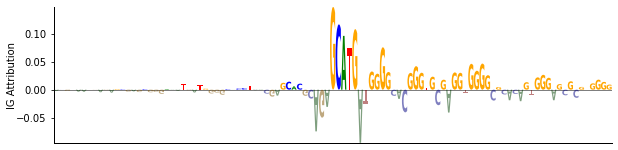

In [10]:
plot_sequence_attribution(attributions)